In [2]:
%config IPCompleter.greedy=True

In [3]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

In [4]:
root_path = './'

## SF Covid-19 Dataset

In [5]:
cases_df = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv')

In [6]:
cases_df.isna().sum()

Date                     0
Transmission Category    0
Case Disposition         0
Case Count               0
dtype: int64

#### We can verify in above query, 0 MISSING values were found 

## Pre-processing steps for SF Covid-19 Dataset

1.   Converting Date column into date-time dtype



In [7]:
cases_df["Date"] = pd.to_datetime(cases_df["Date"], format="%Y/%m/%d")

In [8]:
# Verify by uncommenting and toggling with ascending=True/False
# cases_df.sort_values(by="Date", ascending=False)

## Crime Dataset

In [9]:
crime_df = pd.read_csv(root_path + '/data/Police_Department_Incident_Reports__2018_to_Present.csv')

In [10]:
crime_df["Police District"].value_counts()

Central       53323
Northern      46002
Mission       45971
Southern      42958
Tenderloin    33563
Bayview       27926
Ingleside     24320
Taraval       23231
Richmond      20263
Park          16076
Out of SF      9303
Name: Police District, dtype: int64

In [11]:
crime_df.shape

(342936, 36)

In [12]:
crime_df.isna().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               79225
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            269212
Incident Code                                                0
Incident Category                                          162
Incident Subcategory                                   

## Pre-processing steps for Crime Dataset:


### Considering only non-null columns and Incident columns

In [13]:
columns_to_consider = ["Incident Datetime", 
                       "Incident Date", 
                       "Incident Time", 
                       "Incident Year", 
                       "Incident Day of Week", 
                       "Report Datetime", 
                       "Row ID", 
                       "Incident ID", 
                       "Incident Number", 
                       "Report Type Code", 
                       "Report Type Description", 
                       "Incident Code", 
                       "Incident Category", 
                       "Incident Subcategory", 
                       "Incident Description", 
                       "Resolution", 
                       "Police District"]

In [14]:
crime_df = crime_df[columns_to_consider]

In [15]:
crime_df = crime_df[crime_df["Incident Category"].notna()]

In [16]:
# Verify whhether nulls are removed through the above query
# crime_df.isnull().sum()

In [17]:
crime_df["Incident Date"] = pd.to_datetime(crime_df["Incident Date"], format="%Y/%m/%d")

In [18]:
crime_df["Incident Datetime"] = pd.to_datetime(crime_df["Incident Datetime"], format="%Y/%m/%d %I:%M:%S %p")

## Chi-Square testing Before Lockdown/After Lockdown

In [19]:
from dateutil.relativedelta import relativedelta

earliest_start_date = crime_df["Incident Date"].min()

lockdown_effective_date = datetime.datetime(2020, 3, 17)
first_corona_date = cases_df["Date"].min()
# earliest_start_date = first_corona_date
latest_date = cases_df["Date"].max()
previous_year_start = lockdown_effective_date - relativedelta(years=1)
previous_year_end = latest_date - relativedelta(years=1)

t = crime_df[["Incident ID", "Incident Category"]].drop_duplicates()
t = t["Incident Category"].value_counts()
most_frequent_crimes = list(t[:2].index)

most_frequent_crimes = ["Larceny Theft", "Malicious Mischief"]

In [20]:
before_lockdown_crime = crime_df[(crime_df["Incident Date"] >= previous_year_start) & (crime_df["Incident Date"] <= previous_year_end)]
after_lockdown_crime = crime_df[(crime_df["Incident Date"] >= lockdown_effective_date) & (crime_df["Incident Date"] <= latest_date)]

# Avoiding double counting same incident-category
before_lockdown_crime = before_lockdown_crime[["Incident ID", "Incident Category"]].drop_duplicates()
after_lockdown_crime = after_lockdown_crime[["Incident ID", "Incident Category"]].drop_duplicates()

before_days = (previous_year_end - previous_year_start).days + 1
after_days = (latest_date - lockdown_effective_date).days + 1

# Creating dictionary to hold mean crime types before and after lockdown
before_mean_crimes = before_lockdown_crime["Incident Category"].value_counts().divide(before_days).to_dict()
after_mean_crimes = after_lockdown_crime["Incident Category"].value_counts().divide(after_days).to_dict()

## One-Sided Z-test to verify Real-Time Events like rise in New Testing Facility/Equipments
#### San francisco increased it's testing facilities and equipments on April 22 
##### https://www.nbcbayarea.com/news/local/san-francisco/sf-increases-testing-for-all-essential-workers-residents-with-covid-19-symptoms/2277523/
##### We expect a serious rise in cases after that event
##### Weakly mean of cases after the news is greater than weakly mean cases before the event
##### $H_0: \hat\mu \geq \mu_0$
##### $H_1: \hat\mu < \mu_0$


##### We know that regardless of the original distribution of X, we know by Central Limit Theorem, that $\overline{X} \sim N(\mu, \dfrac{\sigma^2}{n})$
##### where $\mu$ is true mean and $\sigma^2$ is true standard deviation

##### Hence, Z-test is applicable here

In [94]:
confirm_cases = cases_df[cases_df["Case Disposition"] == "Confirmed"]
case_counts = confirm_cases.groupby('Date')['Case Count'].sum().reset_index()

In [95]:
# lockdown_effective_date = datetime.datetime(2020, 3, 17)
effective_date = datetime.datetime(2020, 4, 22)
# effective_date = datetime.datetime(2020, 3, 17)
before_start = effective_date - datetime.timedelta(days=7)
before_end = before_start + datetime.timedelta(days=6)

after_start = effective_date + datetime.timedelta(days=1)
after_end = after_start + datetime.timedelta(days=6)

mean_before = case_counts[(case_counts["Date"] >= before_start) & (case_counts["Date"] <= before_end)]["Case Count"].mean()
mean_after = case_counts[(case_counts["Date"] >= after_start) & (case_counts["Date"] <= after_end)]["Case Count"].mean()


In [96]:
X = case_counts["Case Count"].astype(float).to_numpy()
e_of_x = np.mean(X)
e_of_x_square = np.mean(np.multiply(X, X))

true_standard_deviation_of_X = math.sqrt(e_of_x_square - (e_of_x**2))

z_statistic = (mean_after - mean_before)/(true_standard_deviation_of_X / math.sqrt(7))

In [101]:
z_statistic

0.32322016384373886

##### Since this is a left tailed test we are going to check whether z-statistic $ \leq -Z_{\alpha}$ to reject the null hypothesis
##### i.e. z-statistic $\leq -1.645$ for significance level of 0.05

In [102]:
z_threshold = -1.645 # for significance of 0.05
if z_statistic < z_threshold:
    print("We reject the null hypothesis, there is no effect of new testing facilities")
else:
    print("We failed to reject null hypothesis, there is serious rise in new cases as new testing facilities or equipments increase")

We failed to reject null hypothesis, there is serious rise in new cases as new testing facilities or equipments increase


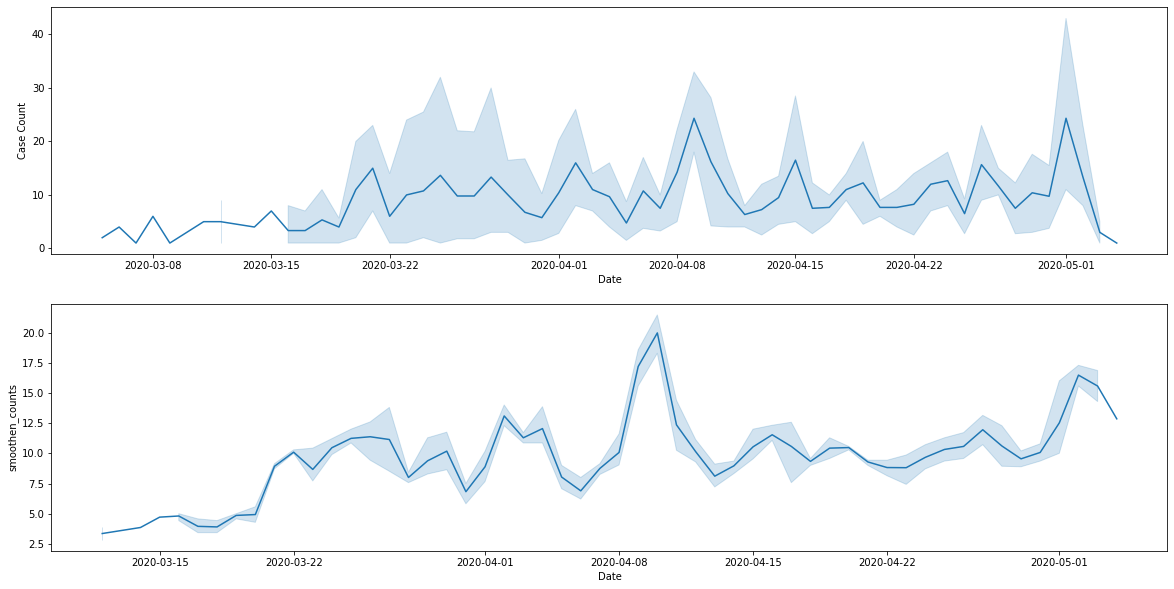

In [108]:
cases_df = cases_df.sort_values(by="Date")
cases_df["smoothen_counts"] = cases_df["Case Count"].rolling(window=7).mean()

figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='Date', y='Case Count', data=cases_df, ax=axes[0])

sns_axes = sns.lineplot(x='Date', y='smoothen_counts', data=cases_df, ax=axes[1])